# Experiment: Label Noise and Fairness-Performance Tradeoff
This experiment evaluates how label noise affects the tradeoff between fairness and performance in a classification task. We implement the 2LR Plugin-Approach (from Bob's paper) and analyze synthetic data under various levels of label noise.

## 1. Import Libraries

In [1]:
from random import seed, shuffle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import pandas as pd
import sys
sys.path.insert(1, '/home/ptr@itd.local/code/fairness_triangle/tools')  # Update this path as needed
from gen_synth_data import *
from plot_helper import *
from corrupt_labels import *
from calc_metrics import *
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import scienceplots
import math
from fractions import Fraction

plt.style.use(["science", "grid"])
plt.rcParams.update({
    'font.size': 16,
    'axes.labelsize': 18,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'grid.linestyle': '--',
    'grid.linewidth': 0.5,
    'grid.alpha': 0.7,
    'xtick.major.pad': 7
})


## 2. Configuration

In [ ]:
rnd_seed = 0             # Fixed randomness for reproducability
flip_prob = 0.1          # Binary Label Noise probability
flip_prob_0_to_1 = 0.1
flip_prob_1_to_0 = 0.3
disc_factor = np.pi/4     # Similarity of Y_sen to X
n_samples = 5000         # Number of samples per distribution (We have 2x in total)
split_ratio = 0.7        # Split into train and test set
c = 0.5                  # Cost of performance and fairness (Eq. 15 )
c_bar = 0.5  
lmd = 0.5                # Trade off between perf and fairn regressions (only used in vizualization)
lmd_start= 0
lmd_end= 2
lmd_interval = np.linspace(lmd_start, lmd_end, 40)
symmetric_fairness = False

## 4. Model Training

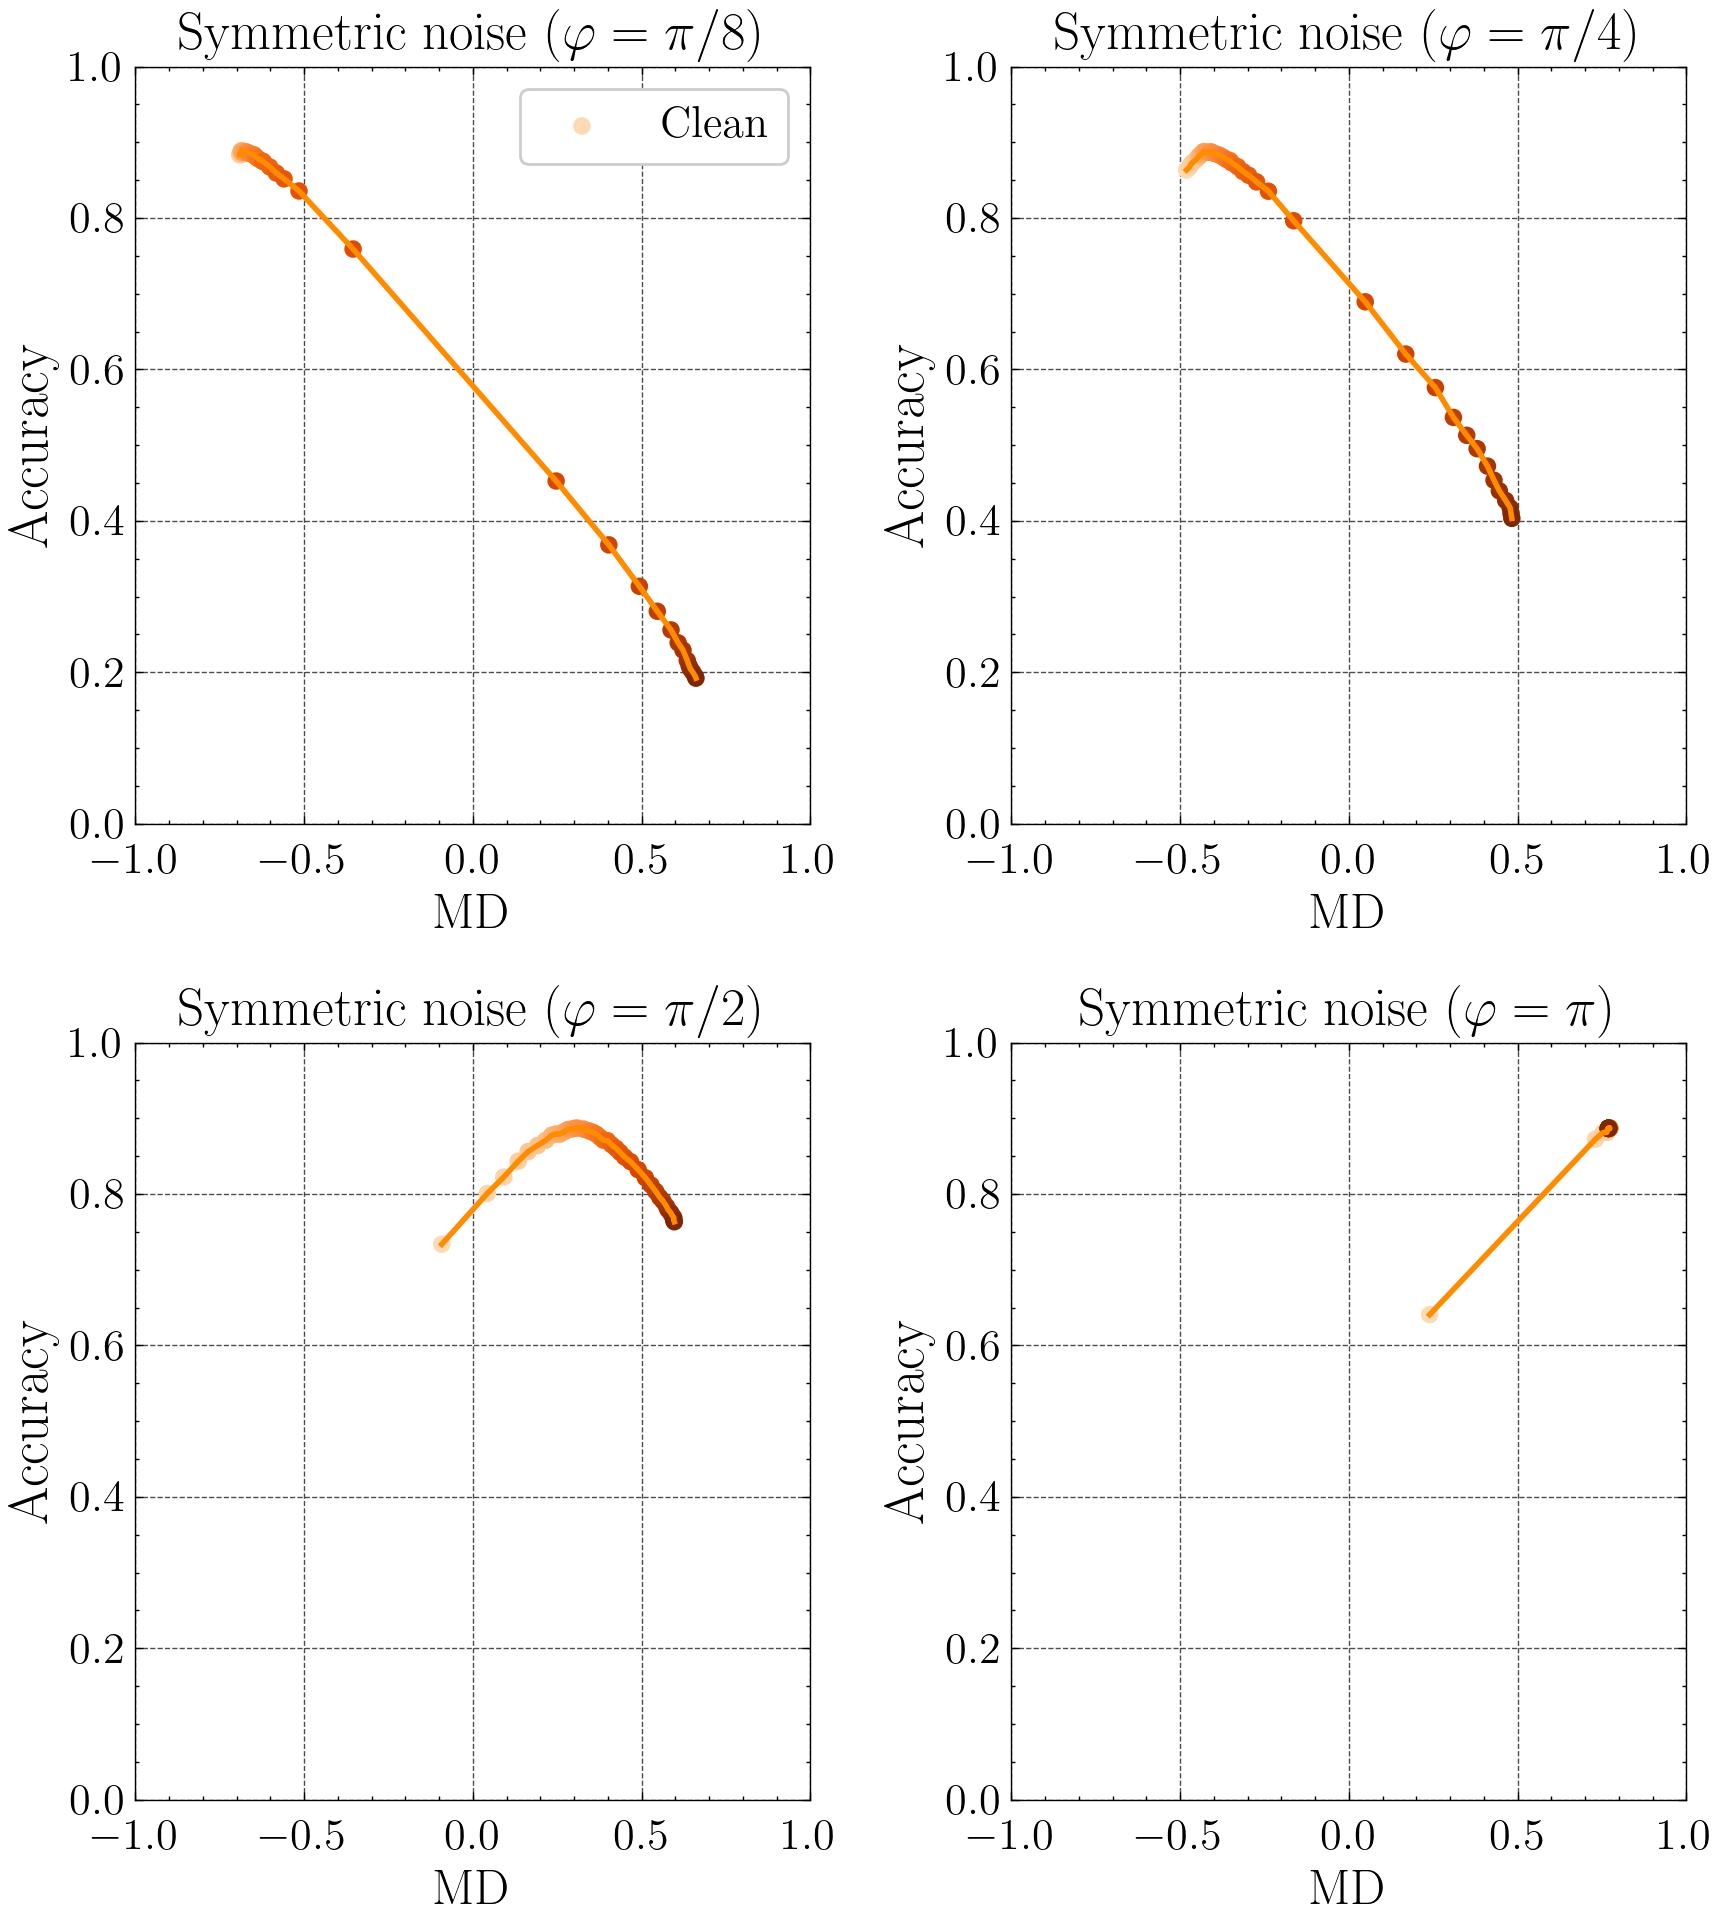

In [3]:
def evaluate_and_plot(X_train, Y_train, X_test, Y_test, Y_sen_test,
                      Y_corr_train, Y_corr_test, p_reg, f_reg, ax, title):
    # fit with corrupted labels
    p_reg_cor = LogisticRegression().fit(X_train, Y_corr_train)

    # sweep over lambda
    BER_list, MD_list, ACC_list = [], [], []
    BER_list_corr, MD_list_corr, ACC_list_corr = [], [], []

    for lmd in lmd_interval:
        # clean predictions
        s = p_reg.predict_proba(X_test)[:, 1] - c - lmd * (f_reg.predict_proba(X_test)[:, 1] - c_bar)
        Y_pred = np.where(s > 0, 1, 0)
        BER_list.append(calc_BER(Y_pred, Y_test))
        MD_list.append(calc_MD(Y_pred, Y_sen_test, symmetric_fairness))
        ACC_list.append(calc_ACC(Y_pred, Y_test))

        # corrupted predictions
        s2 = p_reg_cor.predict_proba(X_test)[:, 1] - c - lmd * (f_reg.predict_proba(X_test)[:, 1] - c_bar)
        Y_pred2 = np.where(s2 > 0, 1, 0)
        BER_list_corr.append(calc_BER(Y_pred2, Y_test))
        MD_list_corr.append(calc_MD(Y_pred2, Y_sen_test, symmetric_fairness))
        ACC_list_corr.append(calc_ACC(Y_pred2, Y_test))

    # pack results (now MD instead of DI)
    results = pd.DataFrame({
        "lambda": lmd_interval,
        "ACC_clean": ACC_list, "ACC_corr": ACC_list_corr,
        "MD_clean": MD_list, "MD_corr": MD_list_corr,
    })

    # plot MD vs ACC
    df = results.sort_values("lambda")
    lambda_norm = (df["lambda"] - df["lambda"].min()) / (df["lambda"].max() - df["lambda"].min())
    orange_cmap = truncate_colormap('Oranges', 0.2, 1.0)
    green_cmap = truncate_colormap('Greens', 0.2, 1.0)

    ax.plot(df["MD_clean"], df["ACC_clean"], color="darkorange", linewidth=2)
    #ax.plot(df["MD_corr"], df["ACC_corr"], color="forestgreen", linewidth=2)

    ax.scatter(df["MD_clean"], df["ACC_clean"], c=lambda_norm, cmap=orange_cmap, s=28, label="Clean")
    #ax.scatter(df["MD_corr"], df["ACC_corr"], c=lambda_norm, cmap=green_cmap, s=28, label="Corrupted", marker="s", alpha=0.6)

    ax.set_title(title)
    ax.set_xlim(-1, 1); ax.set_ylim(0, 1)
    ax.set_xlabel("MD", fontsize=18)
    ax.set_ylabel("Accuracy", fontsize=20)

# =======================
# Build 2x2 grid
# =======================

rnd_seed = 0
flip_prob = 0.45
disc_factors = [np.pi/8, np.pi/4, np.pi/2, np.pi]  # 4 setups
disc_labels = [r"\pi/8", r"\pi/4", r"\pi/2", r"\pi"]
n_samples = 5000
split_ratio = 0.7

fig, axes = plt.subplots(2, 2, figsize=(9, 10))
axes = axes.flatten()  # make it 1D for indexing

for j, (phi, phi_label) in enumerate(zip(disc_factors, disc_labels)):
    # generate data with given phi
    X, Y, Y_sen = generate_synthetic_data(False, n_samples, phi, rnd_seed)
    
    # split into train/test
    split_index = int(split_ratio * len(X))
    X_train, X_test = X[:split_index], X[split_index:]
    Y_train, Y_test = Y[:split_index], Y[split_index:]
    Y_sen_train, Y_sen_test = Y_sen[:split_index], Y_sen[split_index:]

    # add symmetric noise
    Y_corr_train = add_sym_noise(Y_train, flip_prob, rnd_seed)
    Y_corr_test  = add_sym_noise(Y_test,  flip_prob, rnd_seed)

    # fit base regressors
    p_reg = LogisticRegression().fit(X_train, Y_train)
    f_reg = LogisticRegression().fit(X_train, Y_sen_train)

    # just insert the label string directly
    title = fr"Symmetric noise ($\varphi={phi_label}$)"
    evaluate_and_plot(
        X_train, Y_train, X_test, Y_test, Y_sen_test,
        Y_corr_train, Y_corr_test,
        p_reg, f_reg, axes[j], title
    )

    if j == 0:
        axes[j].legend()

fig.tight_layout()
plt.show()


## 7. Reproducibility Notes
- Python version: 3.11.5
- Libraries: numpy, matplotlib, sklearn, pandas
- Custom modules: `gen_synth_data`, `plot_helper`, etc.
- Random seed: 0
